In [24]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

## Simulation

Methods for simulation

In [16]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    # Randomly select training indices without replacement
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    # Sort indices (optional, for consistent ordering)
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    # Create splits
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def introduce_missing_values(Y, missing_percentage):
    # Flatten the array and get total number of elements
    num_elements = Y.size
    num_nan = int(missing_percentage * num_elements)

    # Randomly choose indices to set to NaN
    nan_indices = np.random.choice(num_elements, num_nan, replace=False)

    # Flatten Y to 1D, copy it to avoid modifying the original
    Y_flat = Y.flatten().copy()

    # Replace selected indices with NaN
    Y_flat[nan_indices] = np.nan

    # Reshape back to original shape and return
    return Y_flat.reshape(Y.shape)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

Simulation and plotting

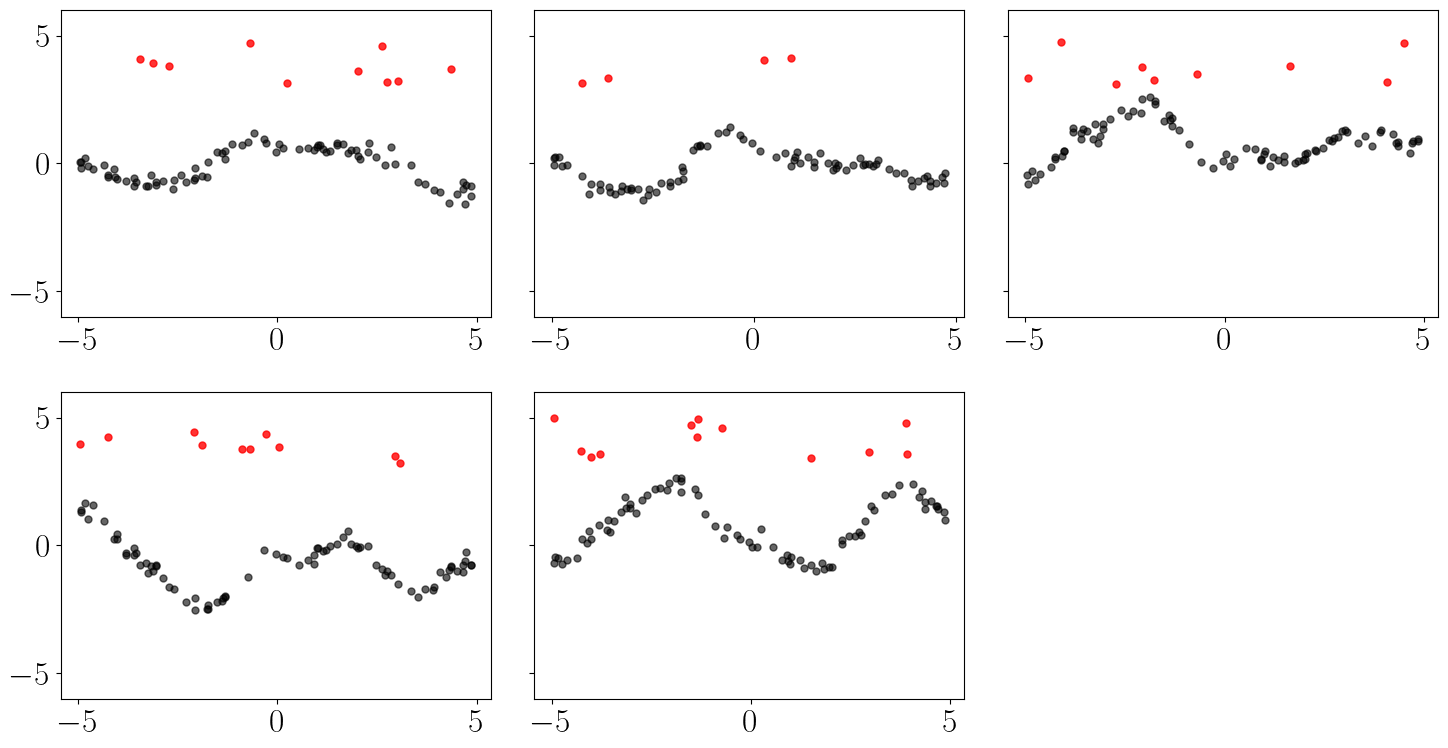

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5  # changed to 5 outputs
missing_percentage = 0.1 
epsilon = 0.1

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

# Define a 5x5 coregionalization matrix B (symmetric and PSD)
B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=1.0, variance=1.0)
K = np.kron(B, Kx)

# Add a small jitter for numerical stability
L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, 0.2, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

# Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
num_outliers = int(epsilon * N * D * (1 - missing_percentage))
# num_outliers = 0
indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
uniform_outliers = np.random.uniform(0, 1, num_outliers)
outlier_values = np.where(
    uniform_outliers < 0.5,
    np.random.uniform(3, 5, num_outliers),
    np.random.uniform(3, 5, num_outliers)
)
Y_train[indices] = outlier_values

# Plotting in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten the indices for convenient comparison
outlier_mask = np.zeros((N, D), dtype=bool)
outlier_mask[indices] = True

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MOGP

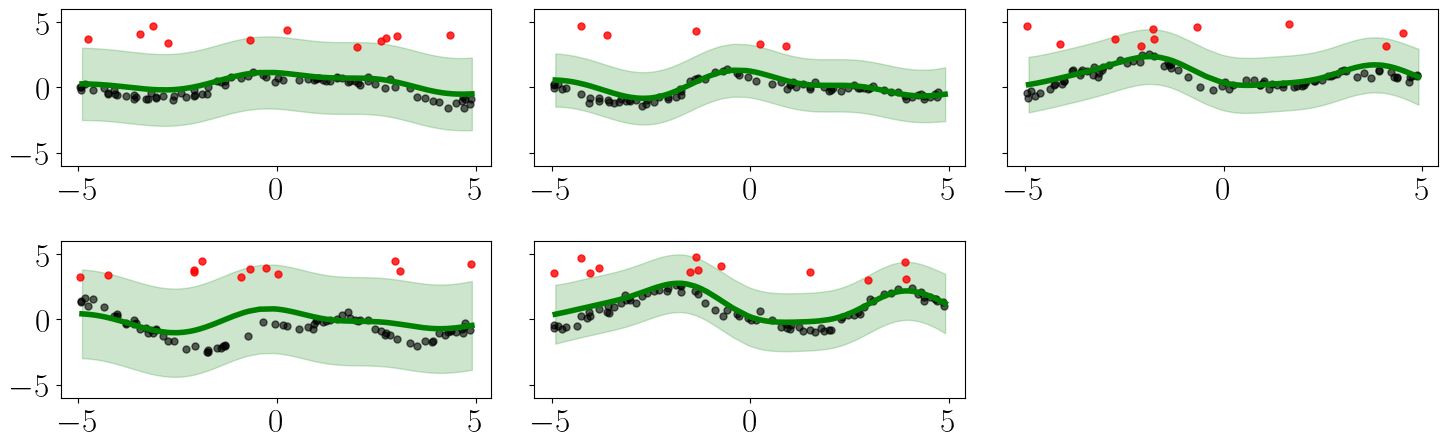

In [14]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
# mogp = MOGPRegressor_NC(mean=0, length_scale=1.0, noise = 0.2, A = 2*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(
    # print_opt_param=True, print_iter_param=True
    )
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

optim_A = mogp.A
optim_noise = mogp.noise
optim_B = optim_A @ optim_A.T
optim_length_scale = mogp.length_scale

# Predict on test points
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MORCGP

-564.5646533121198
-564.5646533213599
-564.5646535553116
-564.56465364158
-564.5646535891825
-564.564653523789
-564.5646535636699
-564.5646533941817
-564.5646532647937
-564.5646533699286
-564.564653339377
-564.5646532845586
-564.5646533521268
-564.5646533233719
-564.5646532981484
-564.5646533694025
-564.5646533380292
-564.5646533719117
-564.5646532825035
-564.5646533624445
-564.5646532599949
-564.5646532954204
-564.5646533169142
-564.5646533409487
-564.564653299969
-564.5646532125736
-564.5646533321162
-564.5646532571051
-564.5646533346123
-564.5646532774156
-564.5646533328257
-564.5646533298612
-514.8273264955698
-514.8273265320037
-514.8273266542524
-514.8273267135354
-514.8273266694445
-514.8273266283711
-514.8273266475409
-514.8273265998963
-514.8273264377233
-514.8273265725043
-514.827326507327
-514.8273264694645
-514.8273264473733
-514.8273265683508
-514.8273264226293
-514.8273264568611
-514.8273265683769
-514.8273264187568
-514.8273265944521
-514.8273263719076
-514.827326555222


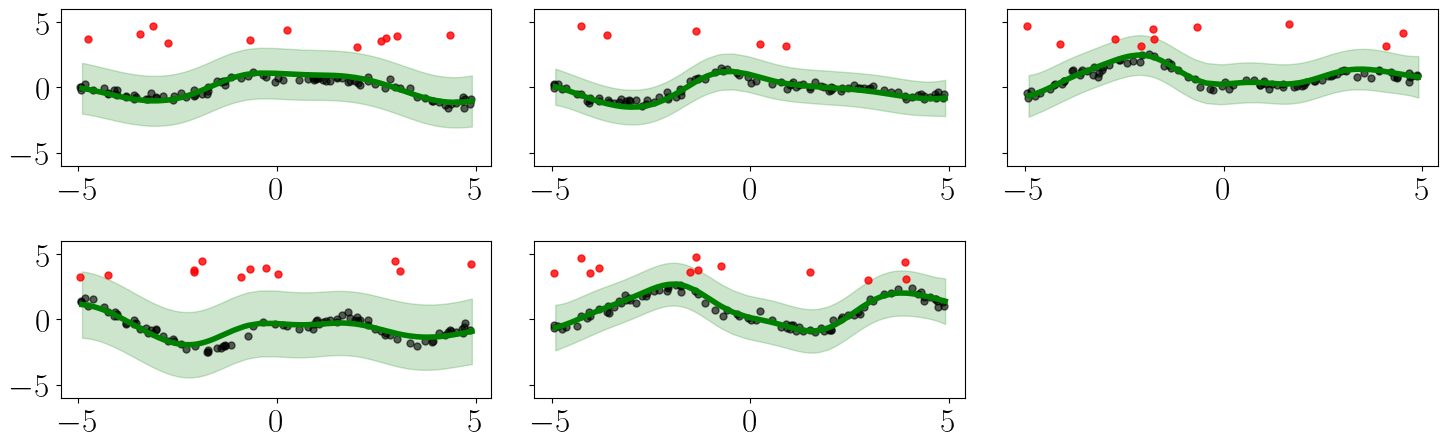

In [4]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

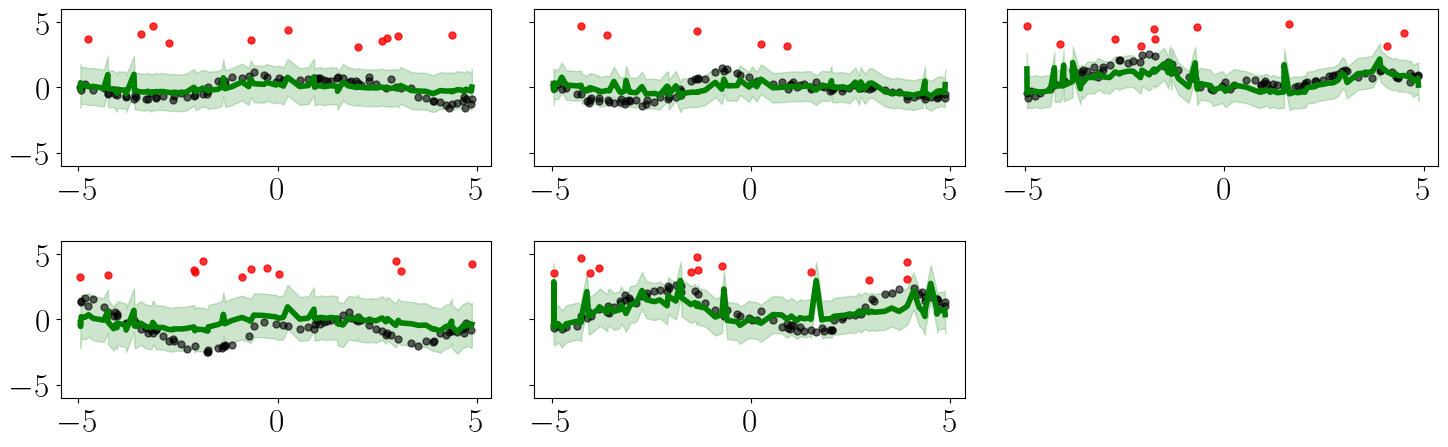

In [ ]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## RCGP

In [ ]:
y_train1, y_train2 = y_train[:, 0].reshape(-1,1), y_train[:, 1].reshape(-1,1)

# Plot 1 ------------------

constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise1, epsilon=epsilon)
rcgp1.fit(x_train, y_train1)
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=True)

mu1, var1 = rcgp1.predict(x_test)
std1 = np.sqrt(var1 + rcgp1.noise)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x_train[mask], y_train1[mask], 'o', color='black', alpha=0.5)
axs[0].plot(x_train[~mask], y_train1[~mask], 'o', color='red')
axs[0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0].plot(x_test, mu1.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu1.ravel() - 1.96 * std1, mu1.ravel() + 1.96 * std1, alpha=0.3, color='royalblue')
axs[0].set_ylim([-6, 6])

# Plot 2 ------------------

rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise2, epsilon=epsilon)
rcgp2.fit(x_train, y_train2)
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=True)

mu2, var2 = rcgp2.predict(x_test)
std2 = np.sqrt(var2 + rcgp2.noise)

axs[1].plot(x_train[mask], y_train2[mask], 'o', color='black', alpha=0.5)
# axs[1].plot(x_train[~mask], y_train2[~mask], 'o', color='red')
axs[1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1].plot(x_test, mu2.ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu2.ravel() - 1.96 * std2, mu2.ravel() + 1.96 * std2, alpha=0.3, color='royalblue')
axs[1].set_ylim([-6, 6])


## Combined

In [21]:
def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    # Avoid zero or negative variances by adding a small number epsilon if needed
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    # Compute NLPD per test point
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    # Average NLPD over all test points
    return np.mean(nlpd_values)

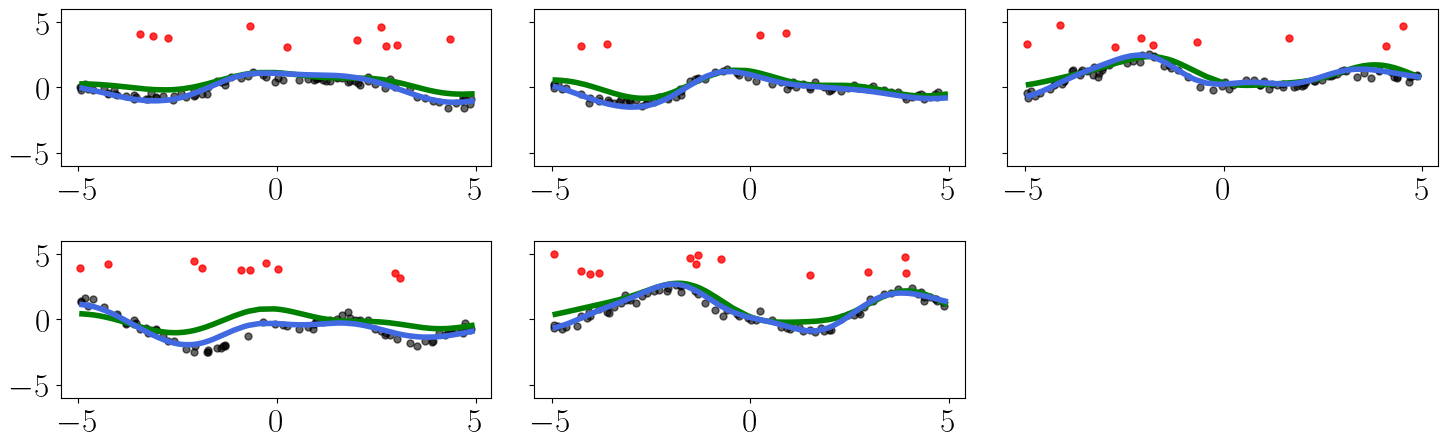

In [23]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [22]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.6306973385969115
RMSE MORCGP: 0.31599905960851926
NLPD MOGP: 1.2328005415796406
NLPD MORCGP: 0.844136326771368
